In [55]:
import sklearn
import torch
import torch.nn as nn

In [56]:
from sklearn.datasets import make_circles

nsamples = 1000
X,y = make_circles(n_samples=nsamples,
                      noise = 0.03,
                      random_state=42)

In [57]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [58]:
X.shape, y.shape

((1000, 2), (1000,))

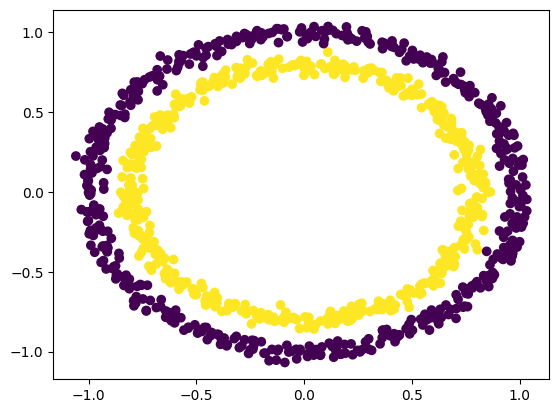

In [59]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y)

In [60]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [62]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [64]:
class CircleClassificationV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2, out_features=5)
        self.linear_layer2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer2(self.linear_layer1(x))

In [65]:
model0 = CircleClassificationV0()
model0.to(device)

CircleClassificationV0(
  (linear_layer1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
# another way to build models
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1))
model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [67]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model0.eval()
with torch.inference_mode():
    untrained_logits = model0(X_test.to(device))
untrained_logits.squeeze().shape, y_test.shape

(torch.Size([200]), torch.Size([200]))

In [68]:
torch.round(untrained_logits[:5])

tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.]])

In [69]:
pred_probs = torch.sigmoid(untrained_logits)
pred_probs[:5]

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [70]:
pred = torch.round(pred_probs)
pred[:5], y_test[:5]

(tensor([[0.],
         [0.],
         [1.],
         [0.],
         [1.]]),
 tensor([1., 0., 1., 0., 1.]))

In [71]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model0.parameters(),
                            lr = 0.01)

In [72]:
def calculate_accuracy(y_true, y_pred):
    currect = torch.eq(y_true, y_pred).sum().item()
    accuracy = (currect / len(y_pred)) * 100
    return accuracy

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs_track = []
loss_track = []
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
epochs = 200
for epoch in range(epochs):
    epochs_track.append(epoch)
    model0.train()
    logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits, y_train)
    loss_track.append(loss)
    accuracy = calculate_accuracy(y_true=y_train,
                                  y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model0.eval()
        with torch.inference_mode():
            test_pred = model0(X_test).squeeze()
        test_loss = loss_fn(test_pred, y_test)
        print(f"epochs: {epoch} | j_train: {loss:.5f} | j_test: {test_loss:.2f} | accuracy: {accuracy:.2f}%")

epochs: 0 | j_train: 0.69796 | j_test: 0.69 | accuracy: 51.88%
epochs: 10 | j_train: 0.69768 | j_test: 0.69 | accuracy: 52.00%
epochs: 20 | j_train: 0.69742 | j_test: 0.69 | accuracy: 52.00%
epochs: 30 | j_train: 0.69717 | j_test: 0.69 | accuracy: 52.00%
epochs: 40 | j_train: 0.69695 | j_test: 0.69 | accuracy: 51.62%
epochs: 50 | j_train: 0.69675 | j_test: 0.69 | accuracy: 51.38%
epochs: 60 | j_train: 0.69656 | j_test: 0.69 | accuracy: 51.38%
epochs: 70 | j_train: 0.69638 | j_test: 0.69 | accuracy: 51.38%
epochs: 80 | j_train: 0.69621 | j_test: 0.69 | accuracy: 51.25%
epochs: 90 | j_train: 0.69606 | j_test: 0.69 | accuracy: 51.38%
epochs: 100 | j_train: 0.69592 | j_test: 0.69 | accuracy: 51.12%
epochs: 110 | j_train: 0.69579 | j_test: 0.69 | accuracy: 51.00%
epochs: 120 | j_train: 0.69567 | j_test: 0.69 | accuracy: 51.12%
epochs: 130 | j_train: 0.69555 | j_test: 0.69 | accuracy: 51.50%
epochs: 140 | j_train: 0.69544 | j_test: 0.69 | accuracy: 51.38%
epochs: 150 | j_train: 0.69534 | j_t

In [74]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0842, -0.2840],
                      [ 0.4637, -0.5447],
                      [-0.3267, -0.1979],
                      [-0.4230,  0.0615],
                      [-0.7005,  0.6438]])),
             ('0.bias', tensor([-0.6038,  0.5324,  0.1158, -0.2243,  0.4318])),
             ('1.weight',
              tensor([[ 0.0837,  0.3099,  0.0414, -0.1225,  0.1399]])),
             ('1.bias', tensor([-0.1615]))])

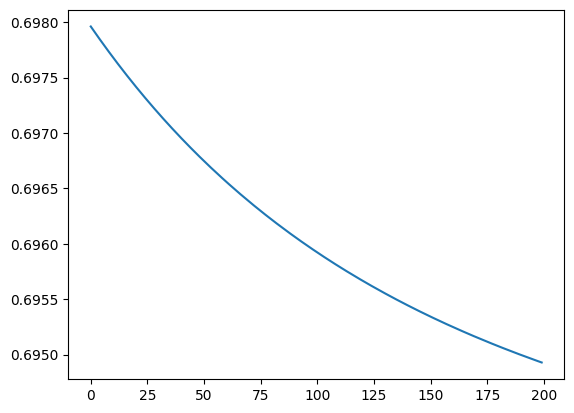

In [77]:
plt.plot(epochs_track, torch.tensor(loss_track).numpy(),)